In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

if not os.path.exists("cifar10.zip"):
  !wget https://people.cs.pitt.edu/~mzhang/cs1699/cifar10.zip
  !unzip cifar10.zip

Streaming output truncated to the last 5000 lines.
 extracting: cifar10_test/truck/truck_00004.png  
 extracting: cifar10_test/truck/truck_00005.png  
 extracting: cifar10_test/truck/truck_00006.png  
 extracting: cifar10_test/truck/truck_00007.png  
 extracting: cifar10_test/truck/truck_00008.png  
 extracting: cifar10_test/truck/truck_00009.png  
 extracting: cifar10_test/truck/truck_00010.png  
 extracting: cifar10_test/truck/truck_00011.png  
 extracting: cifar10_test/truck/truck_00012.png  
 extracting: cifar10_test/truck/truck_00013.png  
 extracting: cifar10_test/truck/truck_00014.png  
  inflating: cifar10_test/truck/truck_00015.png  
 extracting: cifar10_test/truck/truck_00016.png  
 extracting: cifar10_test/truck/truck_00017.png  
 extracting: cifar10_test/truck/truck_00018.png  
 extracting: cifar10_test/truck/truck_00019.png  
 extracting: cifar10_test/truck/truck_00020.png  
 extracting: cifar10_test/truck/truck_00021.png  
 extracting: cifar10_test/truck/truck_00022.png  

This gets the data for us to use into the collab directory. It uses shell commands to efficiently grab the data into the runtime environment.

# Part A

In [3]:
class CifarDataset(Dataset):
  def __init__(self, path, trans=None):
    super().__init__()
    self.data = []
    self.trans = trans
    folders = os.listdir(path)
    for i, folder in enumerate(folders):
      im_path = os.path.join(path, folder)
      ims = os.listdir(im_path)
      for j, im in enumerate(ims):
        self.data.append([os.path.join(im_path,im), i])   #store tuple (image path, label)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    dat = None
    if self.trans is not None:  #For part C
      dat = self.trans(Image.open(self.data[index][0]))
    else:
      im = np.asarray(Image.open(self.data[index][0])).flatten()
      dat = torch.from_numpy(im).type(torch.float)  #Convert the image path into an image array
    return dat, torch.tensor(self.data[index][1])


The dataset creates a list, data, that contains the string path to each image. When an image is requested, it is processed accourding to the transform specified. For part B this is None, and part C it creates the MobileNetV2 expected input.

# Part B

In [4]:
class MultiLayerPerceptronModel(nn.Module):
  def __init__(self, input, hidden, drop):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(input, hidden),
        nn.Tanh(),
        nn.Dropout(drop),
        nn.Linear(hidden, 10)
    )

  def forward(self,x):
    out = self.net(x)
    return out


This is the MLP model. Using a sequential block is to make the forward call simplier. There are 10 classes of images, so the output is 10 nodes.

In [5]:
def training(data, net, opt, loss_fun, epochs,device,batch):
  iterations = tqdm(range(epochs))
  total_loss = np.zeros(shape=(epochs, len(data)))
  mean_loss = np.zeros(shape=epochs)
  for iter in iterations:
    i = 0
    for input, label in data:
      input = input.to(device)
      label = label.to(device)
      out = net(input)  #get prediction
      loss = loss_fun(out, label)
      total_loss[iter][i] = loss.mean()
      loss.backward()
      opt.step()
      opt.zero_grad()
      if (i + 1) % 10 == 0:
        iterations.set_description(
          'Step [{}/{}], Loss: {:.4f}'.format(
              i + 1, len(data), loss.mean()))
      i = i+1
  x = np.arange(0,epochs)
  plt.plot(x, np.mean(total_loss, axis=1))
  plt.savefig(f"{epochs}epochs.jpg")


The training function is simple. For every epoch, and for each batch, move the data to the GPU if needed, then compute predictions and loss, then backpropagate. 

In [6]:
def evaluation(data, net, device):
  results = 0
  total = 0
  for input, label in data:
    input = input.to(device)
    label = label.to(device)
    out = net(input)
    _, prediction = torch.max(out,1) 
    results += (prediction == label).sum().item()
    total += label.size(0)
  return (results/total)*100 

The evaluation function sums the number of times prediction equals the label. Prediction is created by taking the index that contains the maximum value.  

In [7]:
BATCH_SIZE = 250
HIDDEN_SIZE = 2500
ETA = 6e-6
DROP = .04
DECAY = 1e-4
EPOCS = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = CifarDataset("cifar10_train")
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
input_size = len(train_dataset[0][0])
MLP = MultiLayerPerceptronModel(input_size, HIDDEN_SIZE, DROP).to(device)

optim = torch.optim.Adam(MLP.parameters(), ETA, weight_decay=DECAY)
loss_fun = nn.CrossEntropyLoss()

Here we set the hyper parameters and create the objects needed to run the network. 

# Part B Report
I found that a small learning rate worked the best for me. When I tried 1e-4 and 1e-5 I found that the loss was starting higher before slowly decaying. With 1e-6, the loss decreases more rapidly at first before slowly decaying at around the same rate as the other 2 learning rates. I settled on 6e-6 as a good learning rate that steadily declined over every epoch. My loss showed no signs of plataeuing either. Even after 200 epochs, the loss was still decreasing at the same rate as epoch 20. The train accuracy would increase greatly, but test accuracy would not increase by very much.

I found that hidden size stopped affecting the network significantly once it was between 1000 and 2000. With a small hidden size (< 100) the network is not able to learn. But with 1200, 1600, and 1800 the differences in the test accuracy were mild. I got the best results training at the end with 2500, and would test this more if I did not reach google's usage limit.-

Adam was the optimizer that worked best for me. With RMSProp and SGD I used a momentum of .9, and got low accuracy scores. The graphs of mean loss per epoch were not steadily declining for RMSProp and SGD. With Adam, the loss steadily declined over time. 

I did not find difference between dropout values .02 .04 and .08. A dropout of .4 prevented learning, and a small dropout seems to protect from overfitting.

Weight decay values that are small (1e-4) worked best for me. 1e-3 and above resulted in lower testing accuracy. I did not notice a difference between 1e-5 and 1e-6. 

The batch size to use is hard to pick. I settled on 250 because it allowed for quicker training and still seemed to allow for progress while training. With more resources and time, I would use a lower batch size and let the model train using that. When training with only 1/5 of the training set, I used a small batch size of 50 and saw the highest train accuracy of 86%. Using a batch size of 500 did not seem different than 250, but gave slightly lower accuracy scores.

## 10000 Images
Dropout .04

BATCH_SIZE = 50
HIDDEN_SIZE = 1200
ETA = 1e-6
DECAY = 1e-4
EPOCS = 200
Test: 38
Train: 66

BATCH_SIZE = 50
HIDDEN_SIZE = 1800
ETA = 1e-6
DECAY = 1e-4
EPOCS = 200
Test: 39
Train: 72

BATCH_SIZE = 50
HIDDEN_SIZE = 1800
ETA = 1e-6
DECAY = 1e-4
EPOCS = 400
Test: 40
Train: 86

BATCH_SIZE = 50
HIDDEN_SIZE = 1800
ETA = 1e-5
DECAY = 1e-4
EPOCS = 400
Test: 40.8
Train: 58.5

BATCH_SIZE = 50
HIDDEN_SIZE = 1800
ETA = 1e-5
DECAY = 0
EPOCS = 200
Test: 40.9
Train: 49.7

BATCH_SIZE = 32
HIDDEN_SIZE = 1800
ETA = 1e-5
DECAY = 0
EPOCS = 200
Test: 39.5
Train: 45.3

BATCH_SIZE = 100
HIDDEN_SIZE = 1800
ETA = 1e-6
DECAY = 1e-3
EPOCS = 200
Test: 37.39
Train: 67.61


## All images

Dropout = .04

Adam

BATCH_SIZE = 500
HIDDEN_SIZE = 1800
ETA = 1e-6
DECAY = 1e-4
EPOCS = 50
Test: 37.45
Train: 43.25

BATCH_SIZE = 500
HIDDEN_SIZE = 1600
ETA = 1e-5
DECAY = 1e-3
EPOCS = 50
Test: 44.46
Train: 47.8

BATCH_SIZE = 500
HIDDEN_SIZE = 1400
ETA = 1e-5
DECAY = 1e-3
EPOCS = 50
Test: 44.36
Train: 47.79

BATCH_SIZE = 500
HIDDEN_SIZE = 1400
ETA = 5e-5
DECAY = 1e-3
EPOCS = 50
Test: 38.1
Train: 38.43

BATCH_SIZE = 500
HIDDEN_SIZE = 1400
ETA = 8e-6
DECAY = 1e-4
EPOCS = 50
Test: 44.47
Train: 48.29

BATCH_SIZE = 250
HIDDEN_SIZE = 1400
ETA = 6e-6
DECAY = 1e-4
EPOCS = 50
Test: 45.12
Train: 48.66

BATCH_SIZE = 250
HIDDEN_SIZE = 1400
ETA = 6e-6
DECAY = 1e-4
EPOCS = 200
Test: 49.1
Train: 63.64

BATCH_SIZE = 250
HIDDEN_SIZE = 1400
ETA = 6e-6
DECAY = 1e-4
EPOCS = 300
Test: 49.34
Train: 73.23

BATCH_SIZE = 250
HIDDEN_SIZE = 2500
ETA = 6e-6
DECAY = 1e-4
EPOCS = 50
Test: 45.8
Train: 50.2

BATCH_SIZE = 250
HIDDEN_SIZE = 2500
ETA = 6e-6
DECAY = 1e-4
EPOCS = 150
Test: 49.42
Train:61.68

SGD

BATCH_SIZE = 250
HIDDEN_SIZE = 1400
ETA = 6e-6
DECAY = 1e-4
EPOCS = 50
Momentum =.9
Test: 35.1
Train: 36.45

RMSProp


BATCH_SIZE = 250
HIDDEN_SIZE = 1400
ETA = 6e-6
DECAY = 1e-4
EPOCS = 50
Momentum = .9
Test: 34.7
Train: 35.07

In [ ]:
MLP.train()
training(train_dataloader, MLP, optim, loss_fun,EPOCS, device, BATCH_SIZE)

Set the network into train mode, and begin training.

In [ ]:
test_dataset = CifarDataset("cifar10_test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
MLP.eval()
evaluation(test_dataloader, MLP, device)

Set the network into evaluation mode(this turns off dropout), and run on the test data.

In [ ]:
evaluation(train_dataloader, MLP, device)

Check performance on the train data

# Part C

In [ ]:
import torchvision
from torchvision import datasets, models, transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),    #.permute not needed because ToTensor returns CHW not HWC
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = CifarDataset("cifar10_train", trans=preprocess)
test_dataset = CifarDataset("cifar10_test", trans=preprocess)
loss = nn.CrossEntropyLoss()

BATCH_SIZE = 100
ETA = 1e-4
DECAY = 1e-4
EPOCS = 3

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def set_grads(model, grads):
    for param in model.parameters():
      param.requires_grad = grads

In [ ]:
def create_opt(model,lr, wd):
  optimize = []
  for name,param in model.named_parameters():
    if param.requires_grad == True:
      optimize.append(param)

  return torch.optim.Adam(optimize, lr, weight_decay=wd)

### Fine Tuning

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


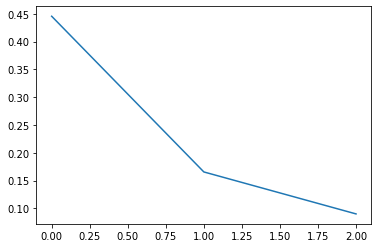

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
set_grads(model, True)
model.classifier[1] = nn.Linear(1280,10,bias=True)  #change model to 10 classes
opt = create_opt(model, ETA, DECAY)
model.to(device)
model.train()
training(train_dataloader, model, opt, loss,EPOCS, device, BATCH_SIZE)


In [ ]:
model.eval()
evaluation(test_dataloader, model, device)

In [ ]:
evaluation(train_dataloader, model, device)

BATCH_SIZE = 100
ETA = 1e-6
DECAY = 0
EPOCS = 4
Test: 18.03

BATCH_SIZE = 100
ETA = 1e-4
DECAY = 0
EPOCS = 3
Test: 92.85 !

BATCH_SIZE = 100
ETA = 1e-3
DECAY = 0
EPOCS = 3
Test: 90.0 !

BATCH_SIZE = 100
ETA = 1e-4
DECAY = 1e-4
EPOCS = 3
Test: 93.51 !
Train: 99.05

### Feature Extract

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


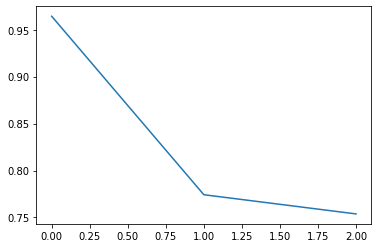

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
set_grads(model, False)
model.classifier[1] = nn.Linear(1280,10,bias=True)
opt = create_opt(model, ETA, DECAY)
model.to(device)
model.train()
training(train_dataloader, model, opt, loss,EPOCS, device, BATCH_SIZE)


In [ ]:
model.eval()
evaluation(test_dataloader, model, device)

75.48

BATCH_SIZE = 100
ETA = 1e-4
DECAY = 0
EPOCS = 3
Test: 72.8

BATCH_SIZE = 100
ETA = 1e-3
DECAY = 0
EPOCS = 3
Test: 75.43

# Part C Report

Feature extract runs in nearly half the time it takes to run fine tuning. This is to be expected as only 1 layer of gradients are being tracked and updated. 

This speed is traded off by fine tuning's better performance. Feature extract does not get mean loss per epoch lower than fine tuning before it starts to plateau. Fine tuning has a lower loss on the first epoch and gets even lower before plateauing. Feature extract does not reach a lower loss once it plataues compared to when fine tuning after only 1 epoch. 

Despite fine tuning taking longer to run per epoch, it produces better results after only 1 epoch compared to feature extract after 3+. I would use fine tuning for future uses because of the better performance. 